# Lecture 12 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

* Based on task for Lecture 11 (+ muscle activation dynamics + pennation angle):

Change the derivative of the contractile element length function. The new function must compute the derivative according to the article from Thelen (2003) (Eqs. (1), (2), (6) and (7)):

     Thelen D; Adjustment of muscle mechanics model parameters to simulate dynamic contractions in older adults (2003)

In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib notebook

### Muscle properties

In [2]:
Lslack = .223
Umax = .04
Lce_o = .093 #optmal l
width = .63#*Lce_o
Fmax = 7400
a = .01
#b = .25*10#*Lce_o

alpha = np.pi/6 #muscle pennation angle (rad)

### Initial conditions

In [3]:
Lnorm_ce = .087/Lce_o #norm
t0 = 0
tf = 5
h = 1e-3

In [4]:
t = np.arange(t0,tf,h)
F = np.empty(t.shape)
Fkpe = np.empty(t.shape)
FiberLen = np.empty(t.shape)
TendonLen = np.empty(t.shape)
a_dynamics = np.empty(t.shape)

<IPython.core.display.Javascript object>


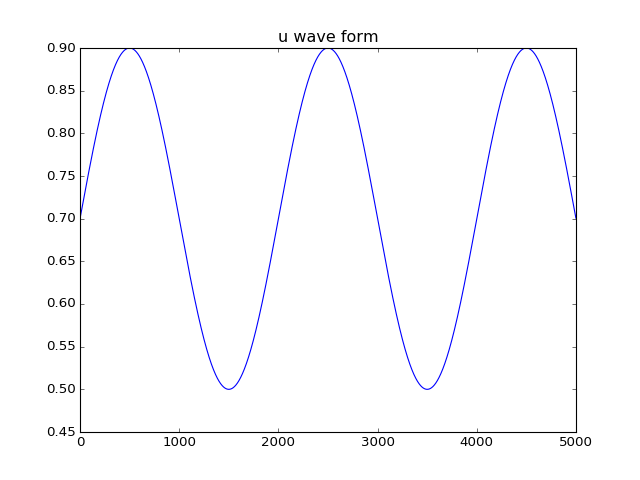

In [5]:
#defining u
form = 'sinusoid'

def createinput_u(form, plot=True):
    if (form == 'sinusoid'):
        u = .2*np.sin(np.pi*t) +.7
    elif (form == 'step'):
        u = np.ones(t.shape)*.01
        u[:1/h] = 1
        u[1/h:3/h] = .5

    elif (form == 'pulse'):
        u = np.ones(t.shape)*.01
        u[1/h:3/h] = 1

    if plot:
        plt.figure()
        plt.plot(u)
        plt.title('u wave form')
    return u   

u = createinput_u (form)

## Simulation - Series

for i in range (len(t)):
    #ramp
    if t[i]<=1:
        Lm = 0.31
    elif t[i]>1 and t[i]<2:
        Lm = .31 + .1*(t[i]-1)
        #print(Lm)
    
    #shortening at 4cm/s
    Lsee = Lm - Lce
    
    if Lsee<Lslack: 
        F[i] = 0
    else: 
        F[i] = Fmax*((Lsee-Lslack)/(Umax*Lslack))**2
        
        
    #isometric force at Lce from CE force length relationship
    F0 = max([0, Fmax*(1-((Lce-Lce_o)/width)**2)])
    
    #calculate CE velocity from Hill's equation
    if  F[i]>F0: print('Error: cannot do eccentric contractions')
    
    Lcedot = -b*(F0-F[i])/(F[i]+a) #vel is negative for shortening
    
    # --- Euler integration step
    Lce += h*Lcedot

    

In [6]:
def TendonForce (Lnorm_see,Lslack, Lce_o):
    '''
    Compute tendon force

    Inputs:
        Lnorm_see = normalized tendon length
        Lslack = slack length of the tendon (non-normalized)
        Lce_o = optimal length of the fiber
    
    Output:
        Fnorm_tendon = normalized tendon force
        
    '''
    Umax = .04
    
    if Lnorm_see<Lslack/Lce_o: 
        Fnorm_tendon = 0
    else: 
        Fnorm_tendon = ((Lnorm_see-Lslack/Lce_o)/(Umax*Lslack/Lce_o))**2
        
    return Fnorm_tendon

In [7]:
def ParallelElementForce (Lnorm_ce):
    '''
    Compute parallel element force
    
    Inputs:
        Lnorm_ce = normalized contractile element length
    
    Output:
        Fnorm_kpe = normalized parallel element force

    '''
    Umax = 1
    
    if Lnorm_ce< 1: 
        Fnorm_kpe = 0
    else: 
        Fnorm_kpe = ((Lnorm_ce-1)/(Umax*1))**2 
        
    return Fnorm_kpe

In [8]:
def ForceLengthCurve (Lnorm_ce,width):
    F0 = max([0, (1-((Lnorm_ce-1)/width)**2)])
    return F0

def ContractileElementDot(F0, Fce, a, b):
    
    '''
    Compute Contractile Element Derivative

    Inputs:
        F0 = Force-Length Curve
        Fce = Contractile element force
    
    Output:
        Lnorm_cedot = normalized contractile element length derivative

    '''
    
    if  Fce>F0: print('Error: cannot do eccentric contractions')
    
    Lnorm_cedot = -b*(F0-Fce)/(Fce + a) #vel is negative for shortening
    
    return Lnorm_cedot

In [9]:
def ContractileElementDot(F0, Fnorm_CE, a):
    
    '''
    Compute Contractile Element Derivative

    Inputs:
        F0 = Force-Length Curve
        Fce = Contractile element force
    
    Output:
        Lnorm_cedot = normalized contractile element length derivative

    '''
    
    FMlen = 1.4 # young adults
    Vmax = 10  # young adults
    Af = 0.25  #force-velocity shape factor
    
    Fnorm_CE = min(FMlen*a*F0 - 0.001, Fnorm_CE)
    
    if  Fnorm_CE > a*F0:
        
        b = ((2 + 2/Af)*(a*F0*FMlen - Fnorm_CE))/(FMlen-1)
        
    elif Fnorm_CE <= a*F0:
        
        b = a*F0 + Fnorm_CE/Af
    
    Lnorm_cedot = (.25 + .75*a)*Vmax*((Fnorm_CE - a*F0)/b)
    
    return Lnorm_cedot

In [10]:
def ContractileElementForce(Fnorm_tendon,Fnorm_kpe,angle):
    '''
    Compute Contractile Element force

    Inputs:
        Fnorm_tendon = normalized tendon force
        Fnorm_kpe = normalized parallel element force
        angle = muscle angle
    
    Output:
        Fce = normalized contractile element force
    '''
    Fce = (Fnorm_tendon - Fnorm_kpe*np.cos(angle))/np.cos(angle)
    return Fce

In [11]:
def tendonLength(Lm,Lce_o,Lnorm_ce,angle):
    '''
    Compute tendon length
    
    Inputs:
        Lm = 
        Lce_o = optimal length of the fiber
        Lnorm_ce = normalized contractile element length
        angle = pennation angle of muscle
    
    Output:
        Lnorm_see = normalized tendon length   
    '''
    Lnorm_see = Lm/Lce_o - Lnorm_ce*np.cos(angle)
    return Lnorm_see

In [12]:
def activation(a,u,dt):
    '''
    Compute activation
    
    Inputs:
        u = idealized muscle excitation signal, 0 <= u <= 1
        a = muscular activation
        dt = time step
    
    Output:
        a = muscular activation  
    '''
    
    tau_deact = 50e-3 #young adults
    tau_act = 15e-3
    
    if u>a:
        tau_a = tau_act*(0.5+1.5*a)
    elif u <=a:
        tau_a = tau_deact/(0.5+1.5*a)
    
    #------- euler
    dadt = (u-a)/tau_a 
    
    a += dadt*dt
    #-------
    return a

## Simulation - Parallel

In [13]:
#Normalizing

for i in range (len(t)):
    #ramp
    if t[i]<=1:
        Lm = 0.31
    elif t[i]>1 and t[i]<2:
        Lm = .31 - .04*(t[i]-1)
        #print(Lm)
    
    #shortening at 4cm/s
    
    Lnorm_see = tendonLength(Lm,Lce_o,Lnorm_ce,alpha)

    Fnorm_tendon = TendonForce (Lnorm_see,Lslack, Lce_o) 
    
    Fnorm_kpe = ParallelElementForce (Lnorm_ce)     
        
    #isometric force at Lce from CE force length relationship
    F0 = ForceLengthCurve (Lnorm_ce,width)
    
    Fce = ContractileElementForce(Fnorm_tendon,Fnorm_kpe,alpha) #Fce = ~Fm
    
    #computing activation
    a = activation(a,u[i],h)
    
    #calculate CE velocity from Hill's equation    
    Lnorm_cedot = ContractileElementDot(F0, Fce,a)
    
    # --- Euler integration step
    Lnorm_ce += h*Lnorm_cedot

    
    F[i] = Fnorm_tendon*Fmax
    Fkpe[i] = Fnorm_kpe*Fmax
    FiberLen[i] = Lnorm_ce*Lce_o
    TendonLen[i] = Lnorm_see*Lce_o
    a_dynamics[i] = a
    

## Plots 

<IPython.core.display.Javascript object>


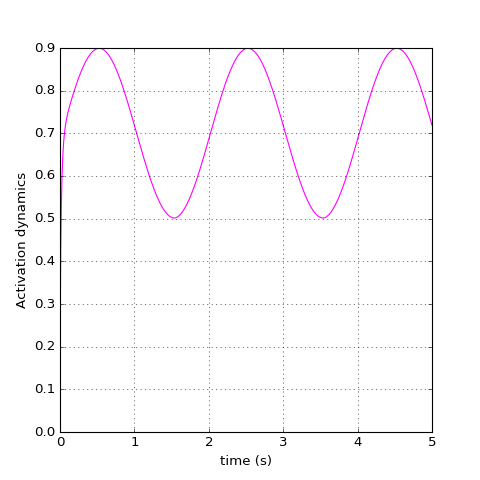

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,a_dynamics,c='magenta')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Activation dynamics')


ax.legend()

<IPython.core.display.Javascript object>


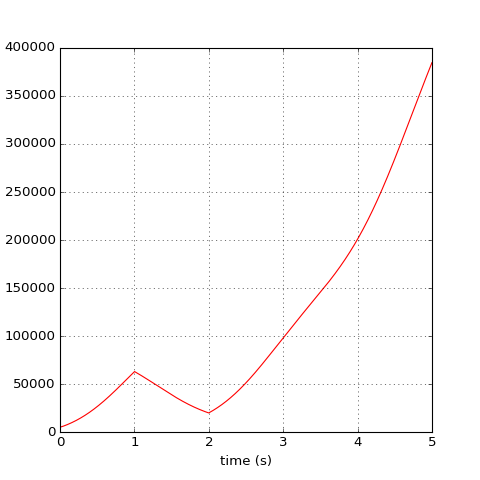

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,F,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)')


ax.legend()

<IPython.core.display.Javascript object>


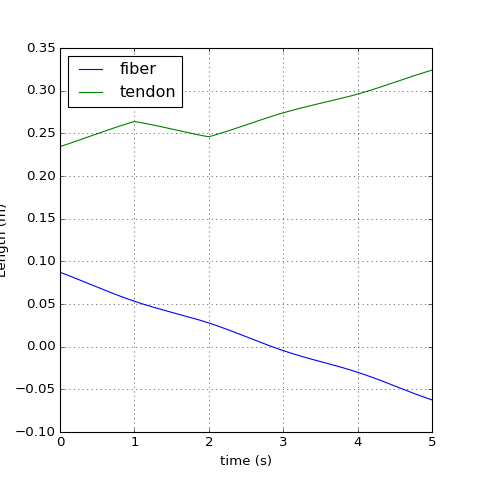

<IPython.core.display.Javascript object>


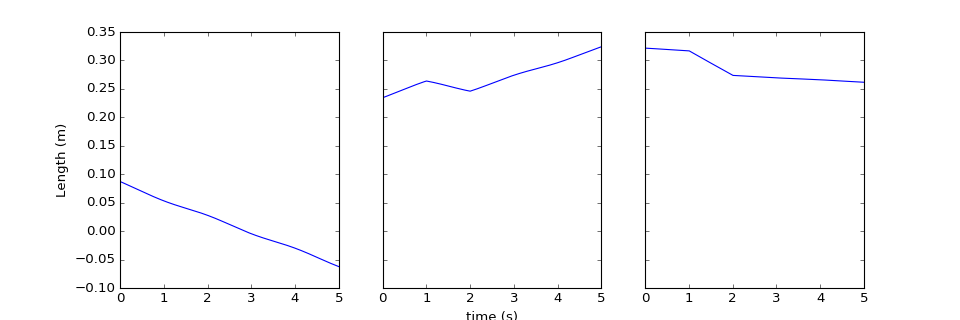

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
ax[0].plot(t,FiberLen, label = 'fiber')
ax[1].plot(t,TendonLen, label = 'tendon')
ax[2].plot(t,FiberLen + TendonLen, label = 'muscle (tendon + fiber)')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)')
#plt.legend(loc='best')

see notebook MuscleSimulation

Add angle alpha
* Ltendon = Lmt - Lm*cos(alpha)
* Lsee = Lm - Lce*cos(alpha)

* Ftendon = (Fce + Fpe)
* Fce = (Ftendon - Fpe*cos(alpha)) / cos(alpha)